## Week 2 Assignment: Zombie Detection

## Installation

In [1]:
# uncomment the next line if you want to delete an existing models directory
!rm -rf ./models/

# clone the Tensorflow Model Garden
!git clone --depth 1 https://github.com/tensorflow/models/

Cloning into 'models'...
remote: Enumerating objects: 4109, done.
remote: Counting objects: 100% (4109/4109), done.
remote: Compressing objects: 100% (3112/3112), done.
remote: Total 4109 (delta 1190), reused 1979 (delta 935), pack-reused 0
Receiving objects: 100% (4109/4109), 45.36 MiB | 33.54 MiB/s, done.
Resolving deltas: 100% (1190/1190), done.


In [2]:
# For compatibility. Pin tf-models-official version so it will use Tensorflow 2.15.
!sed -i 's/tf-models-official>=2.5.1/tf-models-official==2.15.0/g' ./models/research/object_detection/packages/tf2/setup.py

# Compile the Object Detection API protocol buffers and install the necessary packages
!cd models/research/ && protoc object_detection/protos/*.proto --python_out=. && cp object_detection/packages/tf2/setup.py . && python -m pip install .

Processing /kaggle/working/models/research
  Preparing metadata (setup.py) ... done
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 55.4/55.4 kB 3.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 43.6/43.6 kB 2.2 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 152.0/152.0 kB 5.3 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 67.8/67.8 kB 3.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.7/2.7 MB 38.8 MB/s eta 0:00:00a 0:00:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 116.6/116.6 kB 6.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 352.1/352.1 kB 17.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 427.8/427.8 kB 21.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 17.3/17.3 MB 77.1 MB/s eta 0:00:00:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 35.3/35.3 MB

## Imports

In [4]:
import matplotlib
import matplotlib.pyplot as plt

import os
import random
import zipfile
import io
import scipy.misc
import numpy as np

import glob
import imageio
from six import BytesIO
from PIL import Image, ImageDraw, ImageFont
from IPython.display import display, Javascript
from IPython.display import Image as IPyImage
import tensorflow as tf

2024-07-24 09:54:36.029843: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-07-24 09:54:36.029972: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-07-24 09:54:36.195285: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


## Exercise 1: Import Object Detection API packages

In [5]:
from object_detection.utils import label_map_util
from object_detection.utils import config_util
from object_detection.utils import visualization_utils as viz_utils
# from object_detection.utils import colab_utils
from object_detection.builders import model_builder

## Utilities

In [6]:
def load_image_into_numpy_array(path):
    """Load an image from file into a numpy array.

    Puts image into numpy array to feed into tensorflow graph.
    Note that by convention we put it into a numpy array with shape
    (height, width, channels), where channels=3 for RGB.

    Args:
    path: a file path.

    Returns:
    uint8 numpy array with shape (img_height, img_width, 3)
    """
    
    img_data = tf.io.gfile.GFile(path, 'rb').read()
    image = Image.open(BytesIO(img_data))
    (im_width, im_height) = image.size
    
    return np.array(image.getdata()).reshape(
        (im_height, im_width, 3)).astype(np.uint8)

In [7]:
def plot_detections(image_np,
                    boxes,
                    classes,
                    scores,
                    category_index,
                    figsize=(12, 16),
                    image_name=None):
    """Wrapper function to visualize detections.

    Args:
    image_np: uint8 numpy array with shape (img_height, img_width, 3)
    boxes: a numpy array of shape [N, 4]
    classes: a numpy array of shape [N]. Note that class indices are 1-based,
          and match the keys in the label map.
    scores: a numpy array of shape [N] or None.  If scores=None, then
          this function assumes that the boxes to be plotted are groundtruth
          boxes and plot all boxes as black with no classes or scores.
    category_index: a dict containing category dictionaries (each holding
          category index `id` and category name `name`) keyed by category indices.
    figsize: size for the figure.
    image_name: a name for the image file.
    """
    
    image_np_with_annotations = image_np.copy()
    
    viz_utils.visualize_boxes_and_labels_on_image_array(
        image_np_with_annotations,
        boxes,
        classes,
        scores,
        category_index,
        use_normalized_coordinates=True,
        min_score_thresh=0.8)
    
    if image_name:
        plt.imsave(image_name, image_np_with_annotations)
    
    else:
        plt.imshow(image_np_with_annotations)

## Download the Zombie data

In [8]:
# uncomment the next 2 lines if you want to delete an existing zip and training directory
# !rm training-zombie.zip
# !rm -rf ./training

# download the images
!wget --no-check-certificate \
    https://storage.googleapis.com/tensorflow-3-public/datasets/training-zombie.zip \
    -O ./training-zombie.zip

# unzip to a local directory
local_zip = './training-zombie.zip'
zip_ref = zipfile.ZipFile(local_zip, 'r')
zip_ref.extractall('./training')
zip_ref.close()

--2024-07-24 09:59:06--  https://storage.googleapis.com/tensorflow-3-public/datasets/training-zombie.zip
Resolving storage.googleapis.com (storage.googleapis.com)... 172.217.204.207, 142.250.98.207, 173.194.210.207, ...
Connecting to storage.googleapis.com (storage.googleapis.com)|172.217.204.207|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 1915446 (1.8M) [application/zip]
Saving to: './training-zombie.zip'

./training-zombie.z 100%[===================>]   1.83M  --.-KB/s    in 0.02s   

2024-07-24 09:59:06 (97.2 MB/s) - './training-zombie.zip' saved [1915446/1915446]



## Exercise 2: Visualize the training images

In [9]:
%matplotlib inline

### START CODE HERE (Replace Instances of `None` with your code) ###

# assign the name (string) of the directory containing the training images
train_image_dir = './training'

# declare an empty list
train_images_np = []

# run a for loop for each image
for i in range(1, 6):

    # define the path (string) for each image
    image_path = os.path.join(train_image_dir, f'training-zombie{str(i)}.jpg')
    print(image_path)

    # load images into numpy arrays and append to a list
    train_images_np.append(load_image_into_numpy_array(image_path))
### END CODE HERE ###

./training/training-zombie1.jpg
./training/training-zombie2.jpg
./training/training-zombie3.jpg
./training/training-zombie4.jpg
./training/training-zombie5.jpg


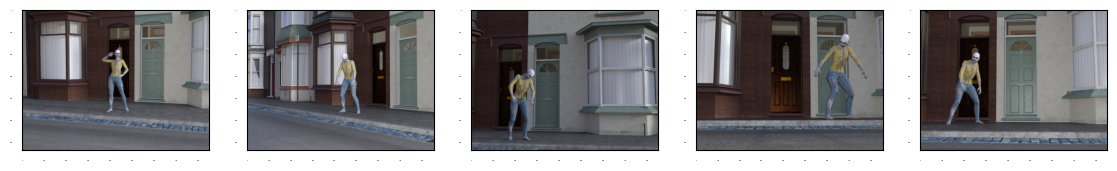

In [10]:
# configure plot settings via rcParams
plt.rcParams['axes.grid'] = False
plt.rcParams['xtick.labelsize'] = False
plt.rcParams['ytick.labelsize'] = False
plt.rcParams['xtick.top'] = False
plt.rcParams['xtick.bottom'] = False
plt.rcParams['ytick.left'] = False
plt.rcParams['ytick.right'] = False
plt.rcParams['figure.figsize'] = [14, 7]

# plot images
for idx, train_image_np in enumerate(train_images_np):
    plt.subplot(1, 5, idx+1)
    plt.imshow(train_image_np)

plt.show()

## Prepare data for training (Optional)

In [17]:
# Define the list of ground truth boxes
gt_boxes = []

In [22]:
# Option 2: use given ground truth boxes
# set this to `True` if you want to override the boxes you drew
override = False

# bounding boxes for each of the 5 zombies found in each image. 
# you can use these instead of drawing the boxes yourself.
ref_gt_boxes = [
        np.array([[0.27333333, 0.41500586, 0.74333333, 0.57678781]]),
        np.array([[0.29833333, 0.45955451, 0.75666667, 0.61078546]]),
        np.array([[0.40833333, 0.18288394, 0.945, 0.34818288]]),
        np.array([[0.16166667, 0.61899179, 0.8, 0.91910903]]),
        np.array([[0.28833333, 0.12543962, 0.835, 0.35052755]]),
      ]

# if gt_boxes is empty, use the reference
if not gt_boxes or override is True:
  gt_boxes = ref_gt_boxes

# if gt_boxes does not contain 5 box coordinates, use the reference 
for gt_box in gt_boxes:
    try:
      assert(gt_box is not None)
    
    except:
      gt_boxes = ref_gt_boxes
      
      break

### View your ground truth box coordinates

In [23]:
# print the coordinates of your ground truth boxes
for gt_box in gt_boxes:
  print(gt_box)

[[0.27333333 0.41500586 0.74333333 0.57678781]]
[[0.29833333 0.45955451 0.75666667 0.61078546]]
[[0.40833333 0.18288394 0.945      0.34818288]]
[[0.16166667 0.61899179 0.8        0.91910903]]
[[0.28833333 0.12543962 0.835      0.35052755]]


## Exercise 3: Define the category index dictionary

In [24]:
### START CODE HERE (Replace instances of `None` with your code ###

# Assign the zombie class ID
zombie_class_id = 1

# define a dictionary describing the zombie class
category_index = {
    zombie_class_id:{
        'id':zombie_class_id,
        'name':'zombie'
    }
}

# Specify the number of classes that the model will predict
num_classes = 1
### END CODE HERE ###

In [25]:
# TEST CODE:

print(category_index[zombie_class_id])

{'id': 1, 'name': 'zombie'}


## Data preprocessing

In [26]:
# The `label_id_offset` here shifts all classes by a certain number of indices;
# we do this here so that the model receives one-hot labels where non-background
# classes start counting at the zeroth index.  This is ordinarily just handled
# automatically in our training binaries, but we need to reproduce it here.

label_id_offset = 1
train_image_tensors = []

# lists containing the one-hot encoded classes and ground truth boxes
gt_classes_one_hot_tensors = []
gt_box_tensors = []

for (train_image_np, gt_box_np) in zip(train_images_np, gt_boxes):
    
    # convert training image to tensor, add batch dimension, and add to list
    train_image_tensors.append(tf.expand_dims(tf.convert_to_tensor(
        train_image_np, dtype=tf.float32), axis=0))
    
    # convert numpy array to tensor, then add to list
    gt_box_tensors.append(tf.convert_to_tensor(gt_box_np, dtype=tf.float32))
    
    # apply offset to to have zero-indexed ground truth classes
    zero_indexed_groundtruth_classes = tf.convert_to_tensor(
        np.ones(shape=[gt_box_np.shape[0]], dtype=np.int32) - label_id_offset)
    
    # do one-hot encoding to ground truth classes
    gt_classes_one_hot_tensors.append(tf.one_hot(
        zero_indexed_groundtruth_classes, num_classes))

print('Done prepping data.')

Done prepping data.


## Visualize the zombies with their ground truth bounding boxes

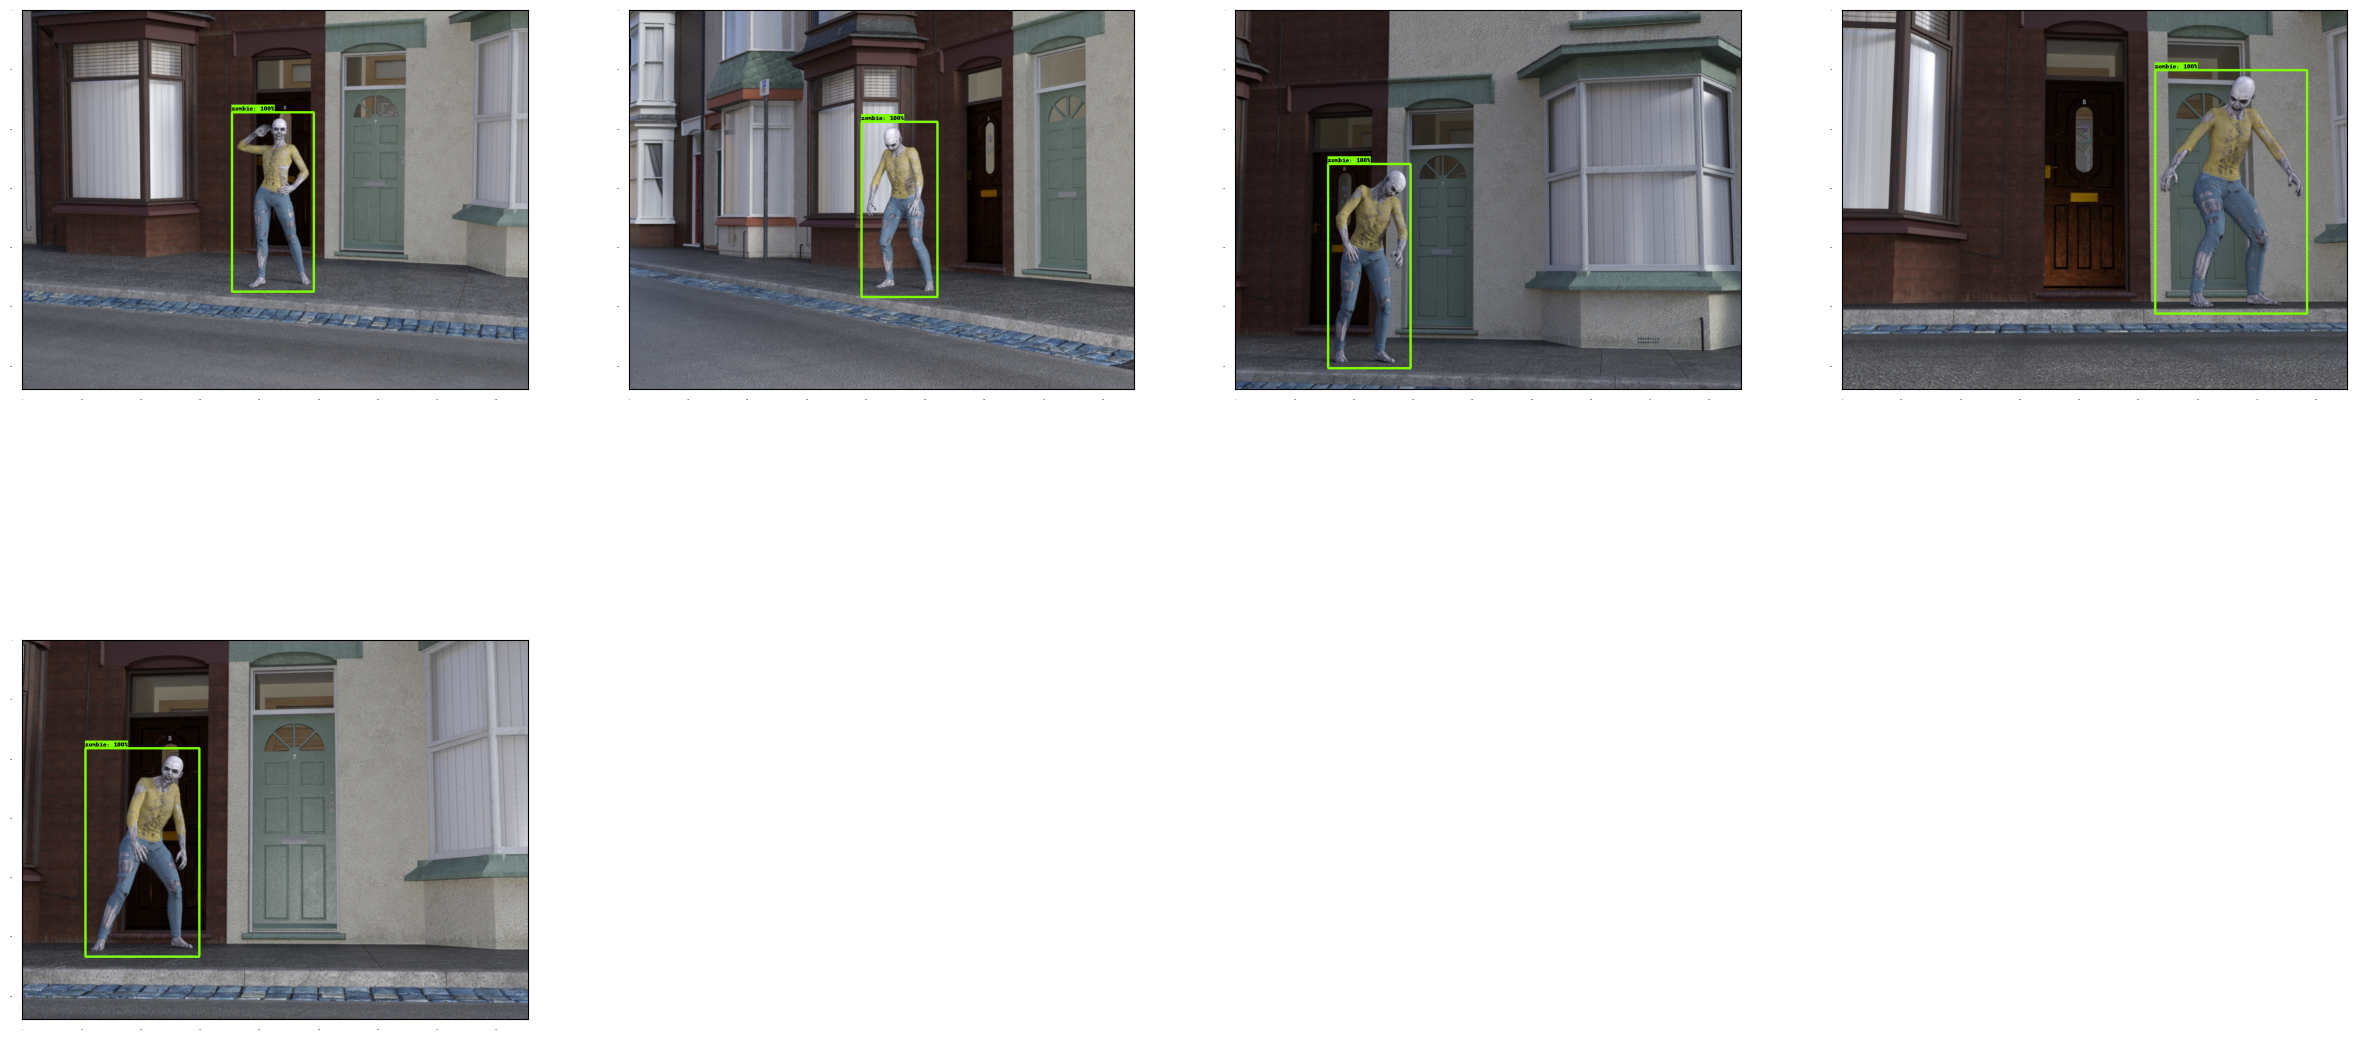

In [27]:
# give boxes a score of 100%
dummy_scores = np.array([1.0], dtype=np.float32)

# define the figure size
plt.figure(figsize=(30, 15))

# use the `plot_detections()` utility function to draw the ground truth boxes
for idx in range(5):
    plt.subplot(2, 4, idx+1)
    plot_detections(
      train_images_np[idx],
      gt_boxes[idx],
      np.ones(shape=[gt_boxes[idx].shape[0]], dtype=np.int32),
      dummy_scores, category_index)

plt.show()

## Download the checkpoint containing the pre-trained weights

In [28]:
### START CODE HERE ###
# Download the SSD Resnet 50 version 1, 640x640 checkpoint
!wget http://download.tensorflow.org/models/object_detection/tf2/20200711/ssd_resnet50_v1_fpn_640x640_coco17_tpu-8.tar.gz
    
# untar (decompress) the tar file
!tar -xf ssd_resnet50_v1_fpn_640x640_coco17_tpu-8.tar.gz

# copy the checkpoint to the test_data folder models/research/object_detection/test_data/
!mv ssd_resnet50_v1_fpn_640x640_coco17_tpu-8/checkpoint models/research/object_detection/test_data/

### END CODE HERE

--2024-07-24 10:21:24--  http://download.tensorflow.org/models/object_detection/tf2/20200711/ssd_resnet50_v1_fpn_640x640_coco17_tpu-8.tar.gz
Resolving download.tensorflow.org (download.tensorflow.org)... 74.125.139.207, 173.194.217.207, 108.177.12.207, ...
Connecting to download.tensorflow.org (download.tensorflow.org)|74.125.139.207|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 244817203 (233M) [application/x-tar]
Saving to: 'ssd_resnet50_v1_fpn_640x640_coco17_tpu-8.tar.gz'

ssd_resnet50_v1_fpn 100%[===================>] 233.48M   101MB/s    in 2.3s    

2024-07-24 10:21:26 (101 MB/s) - 'ssd_resnet50_v1_fpn_640x640_coco17_tpu-8.tar.gz' saved [244817203/244817203]



## Configure the model

### Exercise 5.1: Locate and read from the configuration file

In [34]:
tf.keras.backend.clear_session()


### START CODE HERE ###
# define the path to the .config file for ssd resnet 50 v1 640x640
pipeline_config = '/kaggle/working/models/research/object_detection/configs/tf2/ssd_resnet50_v1_fpn_640x640_coco17_tpu-8.config'

# Load the configuration file into a dictionary
configs = config_util.get_configs_from_pipeline_file(pipeline_config)

### END CODE HERE ###
# See what configs looks like
configs

{'model': ssd {
   num_classes: 90
   image_resizer {
     fixed_shape_resizer {
       height: 640
       width: 640
     }
   }
   feature_extractor {
     type: "ssd_resnet50_v1_fpn_keras"
     depth_multiplier: 1.0
     min_depth: 16
     conv_hyperparams {
       regularizer {
         l2_regularizer {
           weight: 0.00039999998989515007
         }
       }
       initializer {
         truncated_normal_initializer {
           mean: 0.0
           stddev: 0.029999999329447746
         }
       }
       activation: RELU_6
       batch_norm {
         decay: 0.996999979019165
         scale: true
         epsilon: 0.0010000000474974513
       }
     }
     override_base_feature_extractor_hyperparams: true
     fpn {
       min_level: 3
       max_level: 7
     }
   }
   box_coder {
     faster_rcnn_box_coder {
       y_scale: 10.0
       x_scale: 10.0
       height_scale: 5.0
       width_scale: 5.0
     }
   }
   matcher {
     argmax_matcher {
       matched_threshold: 0.5


### Exercise 5.2: Get the model configuration

In [36]:
### START CODE HERE ###
# Read in the object stored at the key 'model' of the configs dictionary
model_config = configs['model']

### END CODE HERE
# see what model_config looks like
model_config

ssd {
  num_classes: 90
  image_resizer {
    fixed_shape_resizer {
      height: 640
      width: 640
    }
  }
  feature_extractor {
    type: "ssd_resnet50_v1_fpn_keras"
    depth_multiplier: 1.0
    min_depth: 16
    conv_hyperparams {
      regularizer {
        l2_regularizer {
          weight: 0.00039999998989515007
        }
      }
      initializer {
        truncated_normal_initializer {
          mean: 0.0
          stddev: 0.029999999329447746
        }
      }
      activation: RELU_6
      batch_norm {
        decay: 0.996999979019165
        scale: true
        epsilon: 0.0010000000474974513
      }
    }
    override_base_feature_extractor_hyperparams: true
    fpn {
      min_level: 3
      max_level: 7
    }
  }
  box_coder {
    faster_rcnn_box_coder {
      y_scale: 10.0
      x_scale: 10.0
      height_scale: 5.0
      width_scale: 5.0
    }
  }
  matcher {
    argmax_matcher {
      matched_threshold: 0.5
      unmatched_threshold: 0.5
      ignore_thresholds: f

### Exercise 5.3: Modify model_config

In [37]:
### START CODE HERE ###
# Modify the number of classes from its default of 90
model_config.ssd.num_classes = num_classes

# Freeze batch normalization
model_config.ssd.freeze_batchnorm = True
detection_model = model_builder.build(
      model_config=model_config, is_training=True)

### END CODE HERE

# See what model_config now looks like after you've customized it!
model_config

ssd {
  num_classes: 1
  image_resizer {
    fixed_shape_resizer {
      height: 640
      width: 640
    }
  }
  feature_extractor {
    type: "ssd_resnet50_v1_fpn_keras"
    depth_multiplier: 1.0
    min_depth: 16
    conv_hyperparams {
      regularizer {
        l2_regularizer {
          weight: 0.00039999998989515007
        }
      }
      initializer {
        truncated_normal_initializer {
          mean: 0.0
          stddev: 0.029999999329447746
        }
      }
      activation: RELU_6
      batch_norm {
        decay: 0.996999979019165
        scale: true
        epsilon: 0.0010000000474974513
      }
    }
    override_base_feature_extractor_hyperparams: true
    fpn {
      min_level: 3
      max_level: 7
    }
  }
  box_coder {
    faster_rcnn_box_coder {
      y_scale: 10.0
      x_scale: 10.0
      height_scale: 5.0
      width_scale: 5.0
    }
  }
  matcher {
    argmax_matcher {
      matched_threshold: 0.5
      unmatched_threshold: 0.5
      ignore_thresholds: fa

### Exercise 5.4: Build the custom model

In [38]:
### START CODE HERE (Replace instances of `None` with your code) ###
detection_model = model_builder.build(model_config=model_config, is_training=True)
### END CODE HERE ###

print(type(detection_model))

<class 'object_detection.meta_architectures.ssd_meta_arch.SSDMetaArch'>


## Restore weights from your checkpoint

### Inspect the detection_model

In [39]:
# Run this to check the type of detection_model
detection_model

### View the variables in detection_model

In [40]:
vars(detection_model)

{'_self_setattr_tracking': True,
 '_obj_reference_counts_dict': ObjectIdentityDictionary({<_ObjectIdentityWrapper wrapping False>: 4, <_ObjectIdentityWrapper wrapping 1>: 1, <_ObjectIdentityWrapper wrapping DictWrapper({})>: 1, <_ObjectIdentityWrapper wrapping True>: 7, <_ObjectIdentityWrapper wrapping <object_detection.anchor_generators.multiscale_grid_anchor_generator.MultiscaleGridAnchorGenerator object at 0x7e63d0ec4e20>>: 1, <_ObjectIdentityWrapper wrapping <object_detection.predictors.convolutional_keras_box_predictor.WeightSharedConvolutionalBoxPredictor object at 0x7e63d0ec6170>>: 1, <_ObjectIdentityWrapper wrapping <object_detection.box_coders.faster_rcnn_box_coder.FasterRcnnBoxCoder object at 0x7e63d38e2140>>: 1, <_ObjectIdentityWrapper wrapping <object_detection.models.ssd_resnet_v1_fpn_keras_feature_extractor.SSDResNet50V1FpnKerasFeatureExtractor object at 0x7e63d0ec6350>>: 1, <_ObjectIdentityWrapper wrapping 'ResNet50V1_FPN'>: 1, <_ObjectIdentityWrapper wrapping <tf.Tensor

### Inspect _box_predictor

In [41]:
# view the type of _box_predictor
detection_model._box_predictor

### View variables in `_box_predictor`

In [42]:
vars(detection_model._box_predictor)

{'_self_setattr_tracking': True,
 '_obj_reference_counts_dict': ObjectIdentityDictionary({<_ObjectIdentityWrapper wrapping False>: 5, <_ObjectIdentityWrapper wrapping True>: 3, <_ObjectIdentityWrapper wrapping 1>: 1, <_ObjectIdentityWrapper wrapping <object_detection.predictors.heads.keras_box_head.WeightSharedConvolutionalBoxHead object at 0x7e63d0ec46a0>>: 1, <_ObjectIdentityWrapper wrapping DictWrapper({'class_predictions_with_background': <object_detection.predictors.heads.keras_class_head.WeightSharedConvolutionalClassHead object at 0x7e63d0ec7b80>})>: 1, <_ObjectIdentityWrapper wrapping ListWrapper(['class_predictions_with_background'])>: 1, <_ObjectIdentityWrapper wrapping <object_detection.builders.hyperparams_builder.KerasLayerHyperparams object at 0x7e63d0ec7e20>>: 1, <_ObjectIdentityWrapper wrapping 256>: 1, <_ObjectIdentityWrapper wrapping 4>: 1, <_ObjectIdentityWrapper wrapping 3>: 1, <_ObjectIdentityWrapper wrapping ListWrapper([])>: 1, <_ObjectIdentityWrapper wrapping Di

## Define checkpoints for desired layers

### Exercise 6.1: Define Checkpoints for the box predictor

In [43]:
### START CODE HERE ###

tmp_box_predictor_checkpoint = tf.train.Checkpoint(
    _base_tower_layers_for_heads = detection_model._box_predictor._base_tower_layers_for_heads,
    _box_prediction_head = detection_model._box_predictor._box_prediction_head
)  
    

### END CODE HERE

In [44]:
# Check the datatype of this checkpoint
type(tmp_box_predictor_checkpoint)

# Expected output:
# tensorflow.python.training.tracking.util.Checkpoint

tensorflow.python.checkpoint.checkpoint.Checkpoint

In [45]:
# Check the variables of this checkpoint
vars(tmp_box_predictor_checkpoint)

{'_root': None,
 '_self_setattr_tracking': True,
 '_self_unconditional_checkpoint_dependencies': [TrackableReference(name=_base_tower_layers_for_heads, ref={'box_encodings': ListWrapper([]), 'class_predictions_with_background': ListWrapper([])}),
  TrackableReference(name=_box_prediction_head, ref=<object_detection.predictors.heads.keras_box_head.WeightSharedConvolutionalBoxHead object at 0x7e63d0ec46a0>)],
 '_self_unconditional_dependency_names': {'_base_tower_layers_for_heads': {'box_encodings': ListWrapper([]),
   'class_predictions_with_background': ListWrapper([])},
  '_box_prediction_head': <object_detection.predictors.heads.keras_box_head.WeightSharedConvolutionalBoxHead at 0x7e63d0ec46a0>},
 '_self_unconditional_deferred_dependencies': {},
 '_self_update_uid': -1,
 '_self_name_based_restores': set(),
 '_self_saveable_object_factories': {},
 '_kwargs': {'_base_tower_layers_for_heads': {'box_encodings': ListWrapper([]),
   'class_predictions_with_background': ListWrapper([])},
  

### Exercise 6.2: Define the temporary model checkpoint

In [46]:
### START CODE HERE ###

tmp_model_checkpoint = tf.train.Checkpoint(
    _box_predictor = tmp_box_predictor_checkpoint,
    _feature_extractor = detection_model._feature_extractor
)  
          
          

### END CODE HERE ###

In [47]:
# Check the datatype of this checkpoint
type(tmp_model_checkpoint)

# Expected output
# tensorflow.python.training.tracking.util.Checkpoint

tensorflow.python.checkpoint.checkpoint.Checkpoint

In [48]:
# Check the vars of this checkpoint
vars(tmp_model_checkpoint)

{'_root': None,
 '_self_setattr_tracking': True,
 '_self_unconditional_checkpoint_dependencies': [TrackableReference(name=_box_predictor, ref=<tensorflow.python.checkpoint.checkpoint.Checkpoint object at 0x7e63d0ec5c00>),
  TrackableReference(name=_feature_extractor, ref=<object_detection.models.ssd_resnet_v1_fpn_keras_feature_extractor.SSDResNet50V1FpnKerasFeatureExtractor object at 0x7e63d0ec6350>)],
 '_self_unconditional_dependency_names': {'_box_predictor': <tensorflow.python.checkpoint.checkpoint.Checkpoint at 0x7e63d0ec5c00>,
  '_feature_extractor': <object_detection.models.ssd_resnet_v1_fpn_keras_feature_extractor.SSDResNet50V1FpnKerasFeatureExtractor at 0x7e63d0ec6350>},
 '_self_unconditional_deferred_dependencies': {},
 '_self_update_uid': -1,
 '_self_name_based_restores': set(),
 '_self_saveable_object_factories': {},
 '_kwargs': {'_box_predictor': <tensorflow.python.checkpoint.checkpoint.Checkpoint at 0x7e63d0ec5c00>,
  '_feature_extractor': <object_detection.models.ssd_resn

### Exercise 6.3: Restore the checkpoint

In [49]:
### START CODE HERE ###

checkpoint_path = 'models/research/object_detection/test_data/checkpoint/ckpt-0'

# Define a checkpoint that sets `model= None
checkpoint = tf.train.Checkpoint(
    model=tmp_model_checkpoint
)

# Restore the checkpoint to the checkpoint path
checkpoint.restore(checkpoint_path)

### END CODE HERE ###

In [50]:
### START CODE HERE (Replace instances of `None` with your code)###

# use the detection model's `preprocess()` method and pass a dummy image
tmp_image, tmp_shapes = detection_model.preprocess(tf.zeros([1, 640, 640, 3]))

# run a prediction with the preprocessed image and shapes
tmp_prediction_dict = detection_model.predict(tmp_image, tmp_shapes)

# postprocess the predictions into final detections
tmp_detections = detection_model.postprocess(tmp_prediction_dict, tmp_shapes)

### END CODE HERE ###

print('Weights restored!')

Weights restored!


In [51]:
# Test Code:
assert len(detection_model.trainable_variables) > 0, "Please pass in a dummy image to create the trainable variables."

print(detection_model.weights[0].shape)
print(detection_model.weights[231].shape)
print(detection_model.weights[462].shape)

(3, 3, 256, 24)
(512,)
(256,)


## Eager mode custom training loop

### Exercise 8: Set training hyperparameters

In [52]:
tf.keras.backend.set_learning_phase(True)

### START CODE HERE (Replace instances of `None` with your code)###

# set the batch_size
batch_size = 4

# set the number of batches
num_batches = 100

# Set the learning rate
learning_rate = 0.01

# set the optimizer and pass in the learning_rate
optimizer = tf.keras.optimizers.SGD(learning_rate=learning_rate, momentum=0.9)

### END CODE HERE ###

/opt/conda/lib/python3.10/site-packages/keras/src/backend.py:452: UserWarning: `tf.keras.backend.set_learning_phase` is deprecated and will be removed after 2020-10-11. To update it, simply pass a True/False value to the `training` argument of the `__call__` method of your layer or model.
  warnings.warn(


## Choose the layers to fine-tune

In [53]:
# Inspect the layers of detection_model
for i,v in enumerate(detection_model.trainable_variables):
    print(f"i: {i} \t name: {v.name} \t shape:{v.shape} \t dtype={v.dtype}")

i: 0 	 name: WeightSharedConvolutionalBoxPredictor/WeightSharedConvolutionalBoxHead/BoxPredictor/kernel:0 	 shape:(3, 3, 256, 24) 	 dtype=<dtype: 'float32'>
i: 1 	 name: WeightSharedConvolutionalBoxPredictor/WeightSharedConvolutionalBoxHead/BoxPredictor/bias:0 	 shape:(24,) 	 dtype=<dtype: 'float32'>
i: 2 	 name: WeightSharedConvolutionalBoxPredictor/WeightSharedConvolutionalClassHead/ClassPredictor/kernel:0 	 shape:(3, 3, 256, 12) 	 dtype=<dtype: 'float32'>
i: 3 	 name: WeightSharedConvolutionalBoxPredictor/WeightSharedConvolutionalClassHead/ClassPredictor/bias:0 	 shape:(12,) 	 dtype=<dtype: 'float32'>
i: 4 	 name: WeightSharedConvolutionalBoxPredictor/BoxPredictionTower/conv2d_0/kernel:0 	 shape:(3, 3, 256, 256) 	 dtype=<dtype: 'float32'>
i: 5 	 name: WeightSharedConvolutionalBoxPredictor/BoxPredictionTower/conv2d_0/BatchNorm/feature_0/gamma:0 	 shape:(256,) 	 dtype=<dtype: 'float32'>
i: 6 	 name: WeightSharedConvolutionalBoxPredictor/BoxPredictionTower/conv2d_0/BatchNorm/feature_0/

### Exercise 9: Select the prediction layer variables

In [54]:
### START CODE HERE (Replace instances of `None` with your code) ###

# define a list that contains the layers that you wish to fine tune
to_fine_tune = []
for v in detection_model.trainable_variables:
    if v.name.startswith('WeightSharedConvolutionalBoxPredictor/WeightSharedConvolutional'):
        to_fine_tune.append(v)


### END CODE HERE

In [55]:
# Test Code:

print(to_fine_tune[0].name)
print(to_fine_tune[2].name)

WeightSharedConvolutionalBoxPredictor/WeightSharedConvolutionalBoxHead/BoxPredictor/kernel:0
WeightSharedConvolutionalBoxPredictor/WeightSharedConvolutionalClassHead/ClassPredictor/kernel:0


## Train your model

In [56]:
# Get a batch of your training images
g_images_list = train_image_tensors[0:2]

In [57]:
# Use .preprocess to preprocess an image
g_preprocessed_image = detection_model.preprocess(g_images_list[0])
print(f"g_preprocessed_image type: {type(g_preprocessed_image)}")
print(f"g_preprocessed_image length: {len(g_preprocessed_image)}")
print(f"index 0 has the preprocessed image of shape {g_preprocessed_image[0].shape}")
print(f"index 1 has information about the image's true shape excluding padding: {g_preprocessed_image[1]}")

g_preprocessed_image type: <class 'tuple'>
g_preprocessed_image length: 2
index 0 has the preprocessed image of shape (1, 640, 640, 3)
index 1 has information about the image's true shape excluding padding: [[640 640   3]]


In [58]:
preprocessed_image_list = []
true_shape_list = []

for img in g_images_list:
    processed_img, true_shape = detection_model.preprocess(img)
    preprocessed_image_list.append(processed_img)
    true_shape_list.append(true_shape)

print(f"preprocessed_image_list is of type {type(preprocessed_image_list)}")
print(f"preprocessed_image_list has length {len(preprocessed_image_list)}")
print()
print(f"true_shape_list is of type {type(true_shape_list)}")
print(f"true_shape_list has length {len(true_shape_list)}")

preprocessed_image_list is of type <class 'list'>
preprocessed_image_list has length 2

true_shape_list is of type <class 'list'>
true_shape_list has length 2


In [59]:
# Try to call `predict` and pass in lists; look at the error message
try:
    detection_model.predict(preprocessed_image_list, true_shape_list)
except AttributeError as e:
    print("Error message:", e)

Error message: Exception encountered when calling layer 'ResNet50V1_FPN' (type SSDResNet50V1FpnKerasFeatureExtractor).

'list' object has no attribute 'get_shape'

Call arguments received by layer 'ResNet50V1_FPN' (type SSDResNet50V1FpnKerasFeatureExtractor):
  • inputs=['tf.Tensor(shape=(1, 640, 640, 3), dtype=float32)', 'tf.Tensor(shape=(1, 640, 640, 3), dtype=float32)']
  • kwargs={'training': 'True'}


In [60]:
# Turn a list of tensors into a tensor
preprocessed_image_tensor = tf.concat(preprocessed_image_list, axis=0)
true_shape_tensor = tf.concat(true_shape_list, axis=0)

print(f"preprocessed_image_tensor shape: {preprocessed_image_tensor.shape}")
print(f"true_shape_tensor shape: {true_shape_tensor.shape}")

preprocessed_image_tensor shape: (2, 640, 640, 3)
true_shape_tensor shape: (2, 3)


In [61]:
# Make predictions on the images
prediction_dict = detection_model.predict(preprocessed_image_tensor, true_shape_tensor)

print("keys in prediction_dict:")
for key in prediction_dict.keys():
    print(key)

keys in prediction_dict:
preprocessed_inputs
feature_maps
anchors
final_anchors
box_encodings
class_predictions_with_background


### Calculate loss

In [62]:
try:
    losses_dict = detection_model.loss(prediction_dict, true_shape_tensor)
except RuntimeError as e:
    print(e)

Groundtruth tensor boxes has not been provided


In [63]:
# Get the ground truth bounding boxes
gt_boxes_list = gt_box_tensors[0:2]

# Get the ground truth class labels
gt_classes_list = gt_classes_one_hot_tensors[0:2]

# Provide the ground truth to the model
detection_model.provide_groundtruth(
            groundtruth_boxes_list=gt_boxes_list,
            groundtruth_classes_list=gt_classes_list)

In [64]:
# Calculate the loss after you've provided the ground truth 
losses_dict = detection_model.loss(prediction_dict, true_shape_tensor)

# View the loss dictionary
losses_dict = detection_model.loss(prediction_dict, true_shape_tensor)
print(f"loss dictionary keys: {losses_dict.keys()}")
print(f"localization loss {losses_dict['Loss/localization_loss']:.8f}")
print(f"classification loss {losses_dict['Loss/classification_loss']:.8f}")

loss dictionary keys: dict_keys(['Loss/localization_loss', 'Loss/classification_loss'])
localization loss 0.08388443
classification loss 1.07556796


In [65]:
# Let's just reset the model so that you can practice setting it up yourself!
detection_model.provide_groundtruth(groundtruth_boxes_list=[], groundtruth_classes_list=[])

## Exercise 10: Define the training step

In [68]:
# decorate with @tf.function for faster training (remember, graph mode!)
@tf.function
def train_step_fn(image_list,
                groundtruth_boxes_list,
                groundtruth_classes_list,
                model,
                optimizer,
                vars_to_fine_tune):
    """A single training iteration.

    Args:
      image_list: A list of [1, height, width, 3] Tensor of type tf.float32.
        Note that the height and width can vary across images, as they are
        reshaped within this function to be 640x640.
      groundtruth_boxes_list: A list of Tensors of shape [N_i, 4] with type
        tf.float32 representing groundtruth boxes for each image in the batch.
      groundtruth_classes_list: A list of Tensors of shape [N_i, num_classes]
        with type tf.float32 representing groundtruth boxes for each image in
        the batch.

    Returns:
      A scalar tensor representing the total loss for the input batch.
    """
    
     # Provide the ground truth to the model
    model.provide_groundtruth(
        groundtruth_boxes_list=groundtruth_boxes_list,
        groundtruth_classes_list=groundtruth_classes_list
    )

    with tf.GradientTape() as tape:
    ### START CODE HERE (Replace instances of `None` with your code) ###

        # Preprocess the images
        
        preprocessed_image_tensor_list = []
        true_shape_tensor_list = []

        for img in image_list:
            processed_img, true_shape = model.preprocess(img)
            preprocessed_image_tensor_list.append(processed_img)
            true_shape_tensor_list.append(true_shape)
            
            
            

        preprocessed_image_tensor = tf.concat(preprocessed_image_tensor_list, axis = 0)
        true_shape_tensor = tf.concat(true_shape_tensor_list, axis = 0)

        # Make a prediction
        prediction_dict = model.predict(preprocessed_image_tensor, true_shape_tensor)

        # Calculate the total loss (sum of both losses)     
        losses_dict = model.loss(prediction_dict, true_shape_tensor)
        total_loss = losses_dict['Loss/localization_loss'] + losses_dict['Loss/classification_loss']

        # Calculate the gradients
        gradients = tape.gradient([total_loss], vars_to_fine_tune)

        # Optimize the model's selected variables
        optimizer.apply_gradients(zip(gradients, vars_to_fine_tune))

        ### END CODE HERE ###
        
    return total_loss

## Run the training loop

In [69]:
print('Start fine-tuning!', flush=True)

for idx in range(num_batches):
    # Grab keys for a random subset of examples
    all_keys = list(range(len(train_images_np)))
    random.shuffle(all_keys)
    example_keys = all_keys[:batch_size]

    # Get the ground truth
    gt_boxes_list = [gt_box_tensors[key] for key in example_keys]
    gt_classes_list = [gt_classes_one_hot_tensors[key] for key in example_keys]
    
    # get the images
    image_tensors = [train_image_tensors[key] for key in example_keys]

    # Training step (forward pass + backwards pass)
    total_loss = train_step_fn(image_tensors, 
                               gt_boxes_list, 
                               gt_classes_list,
                               detection_model,
                               optimizer,
                               to_fine_tune
                              )

    if idx % 10 == 0:
        print('batch ' + str(idx) + ' of ' + str(num_batches)
        + ', loss=' +  str(total_loss.numpy()), flush=True)

print('Done fine-tuning!')

Start fine-tuning!
batch 0 of 100, loss=1.1305373
batch 10 of 100, loss=16.575998
batch 20 of 100, loss=10.211659
batch 30 of 100, loss=0.9060693
batch 40 of 100, loss=0.26400384
batch 50 of 100, loss=0.02958312
batch 60 of 100, loss=0.00095978426
batch 70 of 100, loss=0.006435829
batch 80 of 100, loss=0.00074232195
batch 90 of 100, loss=0.0004927911
Done fine-tuning!


## Load test images and run inference with new model!

In [70]:
# uncomment if you want to delete existing files
!rm zombie-walk-frames.zip
!rm -rf ./zombie-walk
!rm -rf ./results

# download test images
!wget --no-check-certificate \
    https://storage.googleapis.com/tensorflow-3-public/datasets/zombie-walk-frames.zip \
    -O zombie-walk-frames.zip

# unzip test images
local_zip = './zombie-walk-frames.zip'
zip_ref = zipfile.ZipFile(local_zip, 'r')
zip_ref.extractall('./results')
zip_ref.close()

rm: cannot remove 'zombie-walk-frames.zip': No such file or directory
--2024-07-24 11:20:07--  https://storage.googleapis.com/tensorflow-3-public/datasets/zombie-walk-frames.zip
Resolving storage.googleapis.com (storage.googleapis.com)... 74.125.196.207, 173.194.215.207, 108.177.12.207, ...
Connecting to storage.googleapis.com (storage.googleapis.com)|74.125.196.207|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 94778747 (90M) [application/zip]
Saving to: 'zombie-walk-frames.zip'

zombie-walk-frames. 100%[===================>]  90.39M  95.6MB/s    in 0.9s    

2024-07-24 11:20:08 (95.6 MB/s) - 'zombie-walk-frames.zip' saved [94778747/94778747]



In [71]:
test_image_dir = './results/'
test_images_np = []

# load images into a numpy array. this will take a few minutes to complete.
for i in range(0, 237):
    image_path = os.path.join(test_image_dir, 'zombie-walk' + "{0:04}".format(i) + '.jpg')
    print(image_path)
    test_images_np.append(np.expand_dims(
      load_image_into_numpy_array(image_path), axis=0))

./results/zombie-walk0000.jpg
./results/zombie-walk0001.jpg
./results/zombie-walk0002.jpg
./results/zombie-walk0003.jpg
./results/zombie-walk0004.jpg
./results/zombie-walk0005.jpg
./results/zombie-walk0006.jpg
./results/zombie-walk0007.jpg
./results/zombie-walk0008.jpg
./results/zombie-walk0009.jpg
./results/zombie-walk0010.jpg
./results/zombie-walk0011.jpg
./results/zombie-walk0012.jpg
./results/zombie-walk0013.jpg
./results/zombie-walk0014.jpg
./results/zombie-walk0015.jpg
./results/zombie-walk0016.jpg
./results/zombie-walk0017.jpg
./results/zombie-walk0018.jpg
./results/zombie-walk0019.jpg
./results/zombie-walk0020.jpg
./results/zombie-walk0021.jpg
./results/zombie-walk0022.jpg
./results/zombie-walk0023.jpg
./results/zombie-walk0024.jpg
./results/zombie-walk0025.jpg
./results/zombie-walk0026.jpg
./results/zombie-walk0027.jpg
./results/zombie-walk0028.jpg
./results/zombie-walk0029.jpg
./results/zombie-walk0030.jpg
./results/zombie-walk0031.jpg
./results/zombie-walk0032.jpg
./results/

### Exercise 11: Preprocess, predict, and post process an image

In [72]:
# Again, uncomment this decorator if you want to run inference eagerly
@tf.function
def detect(input_tensor):
    """Run detection on an input image.

    Args:
    input_tensor: A [1, height, width, 3] Tensor of type tf.float32.
      Note that height and width can be anything since the image will be
      immediately resized according to the needs of the model within this
      function.

    Returns:
    A dict containing 3 Tensors (`detection_boxes`, `detection_classes`,
      and `detection_scores`).
    """
    preprocessed_image, shapes = detection_model.preprocess(input_tensor)
    prediction_dict = detection_model.predict(preprocessed_image, shapes)
    
    ### START CODE HERE (Replace instances of `None` with your code) ###
    # use the detection model's postprocess() method to get the the final detections
    detections = detection_model.postprocess(prediction_dict, shapes)
    ### END CODE HERE ###
    
    return detections

In [73]:
# Note that the first frame will trigger tracing of the tf.function, which will
# take some time, after which inference should be fast.

label_id_offset = 1
results = {'boxes': [], 'scores': []}

for i in range(len(test_images_np)):
    input_tensor = tf.convert_to_tensor(test_images_np[i], dtype=tf.float32)
    detections = detect(input_tensor)
    plot_detections(
      test_images_np[i][0],
      detections['detection_boxes'][0].numpy(),
      detections['detection_classes'][0].numpy().astype(np.uint32)
      + label_id_offset,
      detections['detection_scores'][0].numpy(),
      category_index, figsize=(15, 20), image_name="./results/gif_frame_" + ('%03d' % i) + ".jpg")
    results['boxes'].append(detections['detection_boxes'][0][0].numpy())
    results['scores'].append(detections['detection_scores'][0][0].numpy())

In [75]:
# TEST CODE

print(len(results['boxes']))
print(results['boxes'][0].shape)
print()

# compare with expected bounding boxes
print(np.allclose(results['boxes'][0], [0.28838485, 0.06830047, 0.7213766 , 0.19833465], rtol=0.18))
print(np.allclose(results['boxes'][5], [0.29168868, 0.07529271, 0.72504973, 0.20099735], rtol=0.18))
print(np.allclose(results['boxes'][10], [0.29548776, 0.07994056, 0.7238164 , 0.20778716], rtol=0.18))

237
(4,)

True
True
True


Frame 0


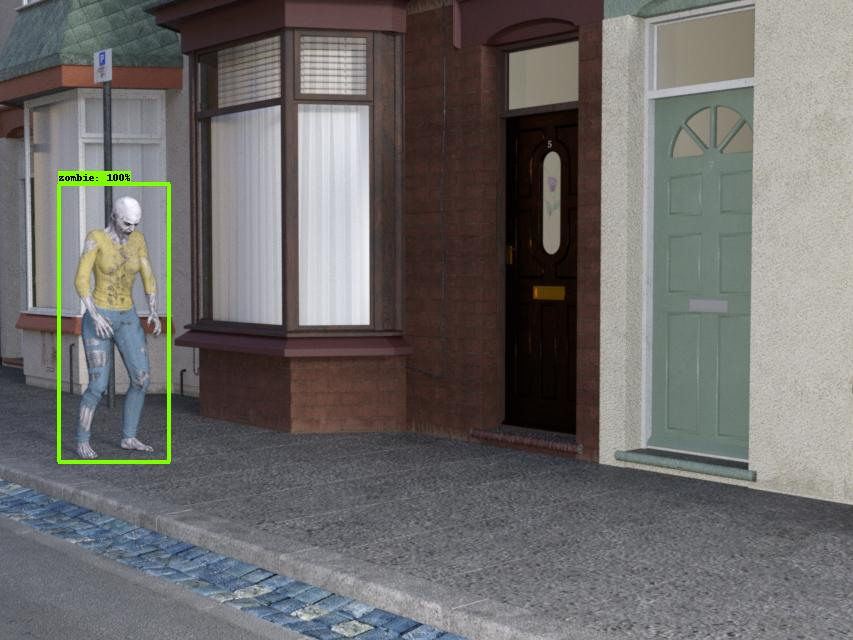


Frame 5


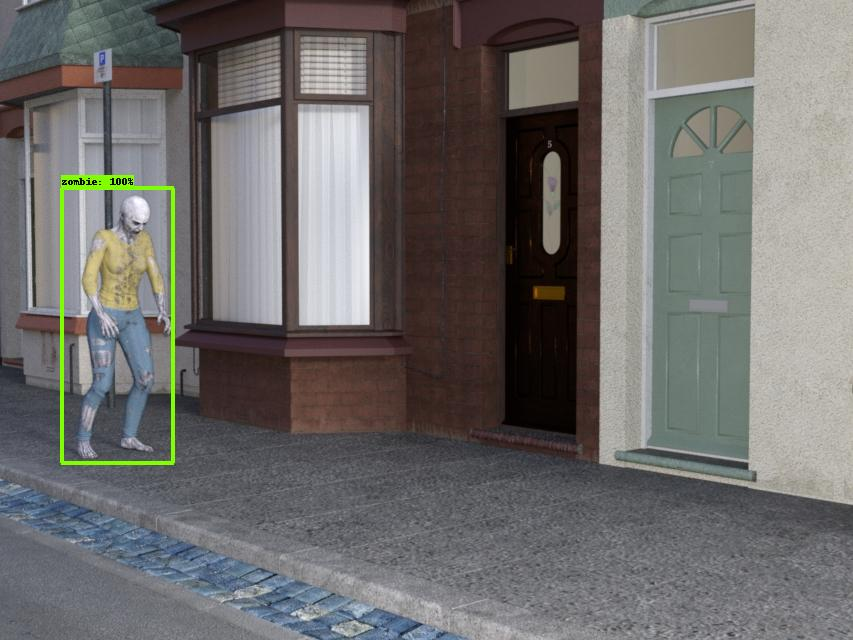


Frame 10


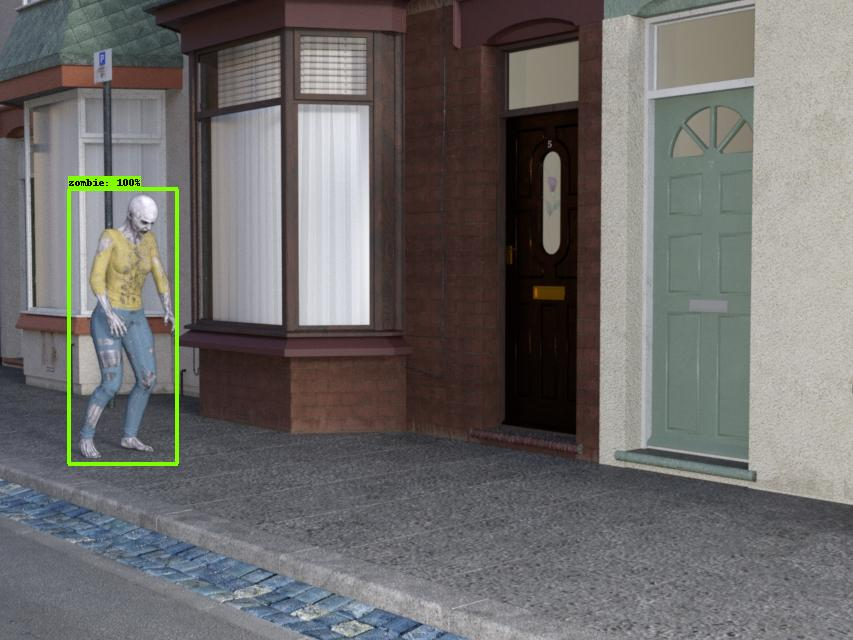

In [76]:
print('Frame 0')
display(IPyImage('./results/gif_frame_000.jpg'))
print()
print('Frame 5')
display(IPyImage('./results/gif_frame_005.jpg'))
print()
print('Frame 10')
display(IPyImage('./results/gif_frame_010.jpg'))

## Create a zip of the zombie-walk images.

In [77]:
zipf = zipfile.ZipFile('./zombie.zip', 'w', zipfile.ZIP_DEFLATED)

filenames = glob.glob('./results/gif_frame_*.jpg')
filenames = sorted(filenames)

for filename in filenames:
    zipf.write(filename)

zipf.close()

## Create Zombie animation

In [78]:
imageio.plugins.freeimage.download()

!rm -rf ./results/zombie-anim.gif

anim_file = './zombie-anim.gif'

filenames = glob.glob('./results/gif_frame_*.jpg')
filenames = sorted(filenames)
last = -1
images = []

for filename in filenames:
    image = imageio.imread(filename)
    images.append(image)

imageio.mimsave(anim_file, images, 'GIF-FI', fps=10)

Imageio: 'libfreeimage-3.16.0-linux64.so' was not found on your computer; downloading it now.
Try 1. Download from https://github.com/imageio/imageio-binaries/raw/master/freeimage/libfreeimage-3.16.0-linux64.so (4.6 MB)
Downloading: 8192/4830080 bytes (0.2%4830080/4830080 bytes (100.0%)
  Done
File saved as /root/.imageio/freeimage/libfreeimage-3.16.0-linux64.so.


/tmp/ipykernel_32/323055697.py:13: DeprecationWarning: Starting with ImageIO v3 the behavior of this function will switch to that of iio.v3.imread. To keep the current behavior (and make this warning disappear) use `import imageio.v2 as imageio` or call `imageio.v2.imread` directly.
  image = imageio.imread(filename)
